## Custom Figures - Rader & Barnes 2023

In [3]:
import pickle
import numpy as np
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import importlib as imp
import seaborn as sb
import cartopy.crs as ccrs

import experiments
import base_directories
import build_data
import save_load_model_run
import model_diagnostics
import metrics
import plots
import matplotlib as mpl

In [4]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
plt.style.use('seaborn-notebook')
dpiFig = 300

In [5]:
N_ANALOGS = 10

# Figure 5 - Isolation and Occlusion for ENSO Seasonal Predictions

In [6]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

In [7]:
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



In [8]:
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
landmask = build_data.maskout_land_ocean(None, maskout=settings["maskout_landocean_input"]).squeeze()[..., None]
landmask[landmask == 0] = np.nan

Assess the skill score for various levels of global occlusion on validation data

In [9]:
soi_input = soi_val_input
soi_output = soi_val_output

percent_thresholds = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99, 99.5])
occlusion_error = []

for percent_thresh in percent_thresholds:

    # Occlude the mask
    omask = mask.copy()
    omask [omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0

    # Plot the occluded mask if every 10%
    if percent_thresh % 10 == 0:
        fig_savename = 'occlusionmask_thresh=' + str(percent_thresh)

        num_maps = omask.shape[-1]
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
        for imap in range(num_maps):
            climits = (omask.min(), omask.max())
            ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                                central_longitude=215., climits = climits, title_text= str(percent_thresh) + "% Occluded Mask",
                                                subplot=(1, num_maps, imap + 1), use_text=False)

        plt.tight_layout()
        
        plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    
    # 

    n_processes = 8
    n_analogues = [N_ANALOGS,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    occlusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )
    

KeyboardInterrupt: 

<Figure size 270x180 with 0 Axes>

In [ ]:
rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(occlusion_error) / error_climo

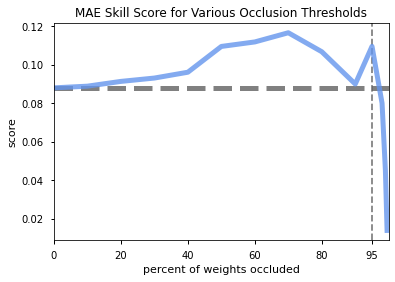

In [ ]:
linewidth = 5
alpha = .8

plt.axhline(y_plot[0], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.plot(percent_thresholds, y_plot, label='Truth', color='cornflowerblue', linewidth=linewidth, alpha=alpha)
plt.axvline(95, color = 'k', linestyle='--', zorder=0, alpha = .5)
plt.ylabel('score')
plt.xlabel('percent of weights occluded')
plt.xlim(0, 100)
xticks = [0, 20, 40, 60, 80, 95]
plt.xticks(xticks)
#plt.yticks([-2, 0, 2])

#plt.ylim(-.4, .4)
plt.grid(False)

plt.title('MAE Skill Score for Various Occlusion Thresholds')

fig_savename = 'FigureS3'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

## Exploring region-by-region occlusion

In [ ]:
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
landmask = build_data.maskout_land_ocean(None, maskout="land").squeeze()[..., None]
landmask[landmask == 0] = np.nan

soi_input = soi_test_input
soi_output = soi_test_output

percent_thresh = 95

# Define regions
reg1=[(100, 0), (70, 40)] # Bottom left corner (lon, lat) and length (lon, lat)
reg2=[(170, -25), (125, 35)]
reg3=[(220, 10), (30, 30)]
reg4=[(280, 0), (60, 20)]

regions_rect = [reg1, reg2, reg3, reg4]
regions = [((reg[0][1], reg[0][1]+reg[1][1]),
            (reg[0][0], reg[0][0]+reg[1][0]),) for reg in regions_rect]

def get_regions_mask(regions):
    region_mask = np.zeros_like(landmask)
    for reg in regions:
        region_mask_lat = np.zeros_like(region_mask)
        region_mask_lon = np.zeros_like(region_mask)
        region_mask_lat[np.logical_and(lat > reg[0][0], lat < reg[0][1]), ...] = 1
        region_mask_lon[:, np.logical_and(lon > reg[1][0], lon < reg[1][1]), ...] = 1
        region_mask = region_mask + region_mask_lat*region_mask_lon
    return region_mask

region_mask = get_regions_mask(regions)

omask = mask.copy()
omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
#omask = omask * region_mask

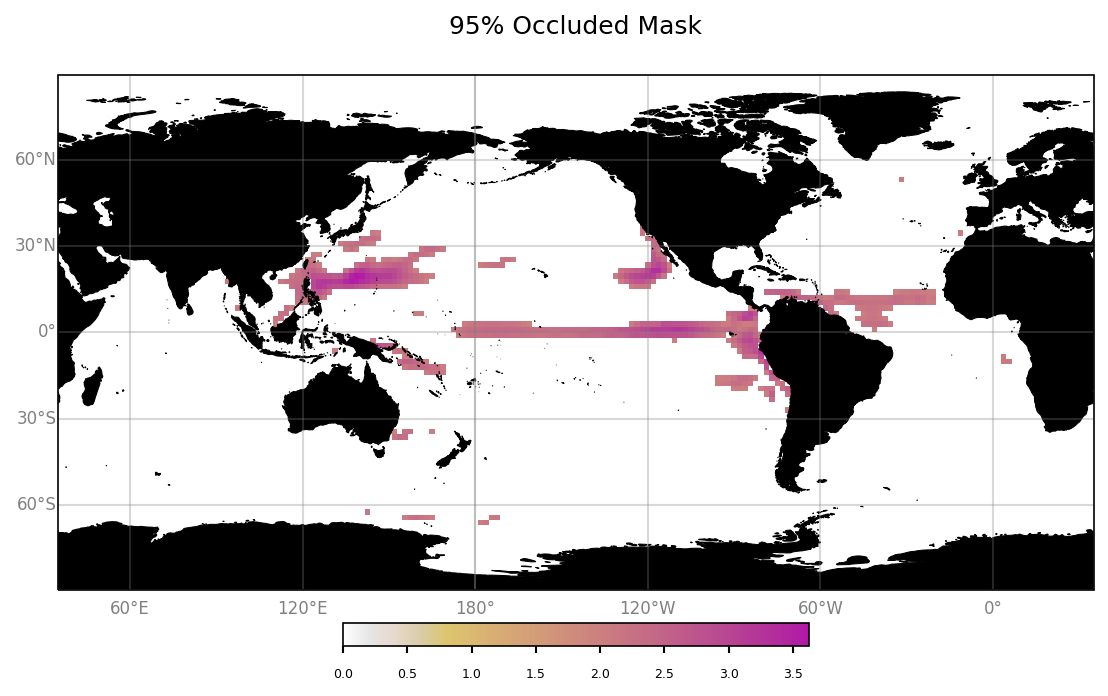

In [ ]:
linewidth = 1
alpha = .8

add_boxes = False
fig_savename = 'occluded_mask_regionboxes=' + str(add_boxes)
num_maps = omask.shape[-1]
fig = plt.figure(figsize=(7.5 * num_maps, 5))
for imap in range(num_maps):
    climits = (omask.min(), omask.max())
    ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                        central_longitude=215., climits = climits, title_text= str(percent_thresh) + "% Occluded Mask",
                                        subplot=(1, num_maps, imap + 1), use_text=False, edgecolor='darkslateblue',
                                        region_bool=add_boxes, cbarpad=.05)
    
    gl = ax.gridlines(draw_labels=True, color='gray', linestyle='-', linewidth=linewidth, alpha=.3)
    gl.xlabel_style = {'size': 8, 'color': 'gray'}
    gl.ylabel_style = {'size': 8, 'color': 'gray'}
    gl.xpadding = 5
    gl.ypadding = 5

    plt.draw()

    for l in gl.ylabel_artists:
        if l._x > -40:
            l.set(alpha=0)

    for l in gl.xlabel_artists:
        if l._y > 0:
            l.set(alpha=0)
    
    if add_boxes:
        rects = dict()
        extra_string = ['W Pac', 'ENSO', 'PMM', 'C Atl']
        for ireg, reg in enumerate(regions_rect):
            rects[ireg] = matplotlib.patches.Rectangle(reg[0], reg[1][0], reg[1][1], facecolor='none', edgecolor = 'orange', 
                                            linewidth=2, transform=ccrs.PlateCarree(), zorder=10)

            ax.add_patch(rects[ireg])
            ax.text(reg[0][0], reg[0][1] + reg[1][1] + 1, str(ireg + 1) + ' - ' + extra_string[ireg], transform=ccrs.PlateCarree(), color='orange')
        
        

plt.tight_layout()
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')


#### Exclude each region and then do predictions.

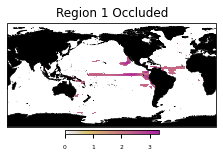

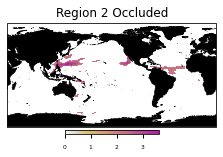

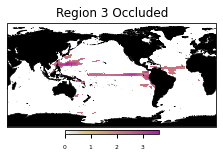

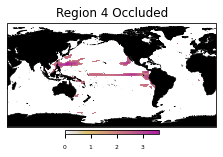

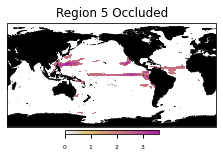

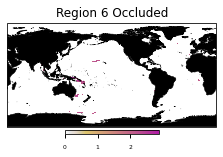

In [ ]:
region_occlusion_error = []
masked_occlusion_weight_sum = []

for i in range(len(regions) + 2):
    this_regions = regions.copy()
    if i < len(regions):
        this_regions = [this_regions[i]]
    elif i == len(regions):
        this_regions = []
    # else keep everything for this_regions == len +1

    region_mask = get_regions_mask(this_regions)
    region_mask = (region_mask - 1) * -1

    # Adjust the mask
    omask = mask.copy()
    omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
    omask = omask * region_mask

    masked_occlusion_weight_sum.append(np.sum(omask))

    num_maps = omask.shape[-1]
    fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
    for imap in range(num_maps):
        climits = (omask.min(), omask.max())
        ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                            central_longitude=215., climits = climits, title_text= "Region " + str(i+1) + " Occluded",
                                            subplot=(1, num_maps, imap + 1), use_text=False, region_bool=False)
    fig_savename = 'discludedmask_reg=' + str(i+1)
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### DO THE PERFORMANCE CALCULATIONS

    n_processes = 8
    n_analogues = [N_ANALOGS,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    region_occlusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )

In [ ]:
rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(region_occlusion_error) / error_climo

Text(0.5, 1.0, 'MAE Skill Score for Regional Occlusions')

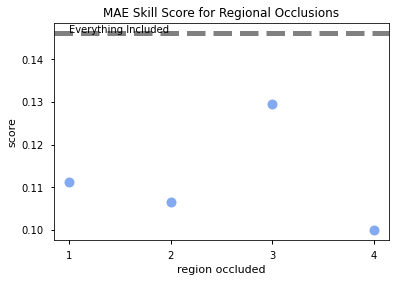

In [ ]:
linewidth = 5
markersize = 10
alpha = .8

plt.figure()
plt.axhline(y_plot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.text(1, y_plot[-2], 'Everything Included')
#plt.axhline(y_plot[-1], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
#plt.text(1, y_plot[-1], 'All Regions Discluded')
plt.plot([1,2,3,4], y_plot[:-2], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

plt.ylabel('score')
plt.xlabel('region occluded')
plt.xticks([1,2,3,4])

plt.grid(False)

plt.title('MAE Skill Score for Regional Occlusions')
#plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
# plt.figure(figsize=(4,2))
# plt.plot(masked_occlusion_weight_sum[:], y_plot[:], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

# for i, xloc, yloc in zip(range(len(y_plot)), masked_occlusion_weight_sum[:], y_plot[:]):
#     plt.text(xloc, yloc, str(i + 1), size=15)

# plt.xlabel('sum of included weights')
# plt.ylabel('score')

#### Include each region and then do predictions.

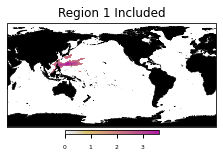

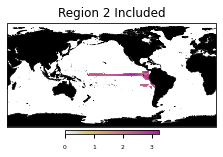

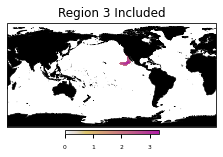

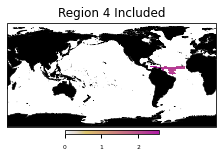

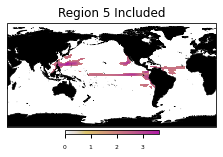

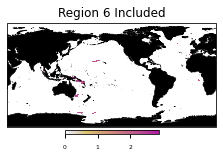

In [ ]:
region_inclusion_error = []
masked_inclusion_weight_sum = []

for i in range(len(regions) + 2):
    if i < len(regions):
        this_regions = regions[i:i+1]
    else:
        this_regions = regions
    region_mask = get_regions_mask(this_regions)

    if i == len(regions) + 1:
        region_mask = (region_mask - 1) * -1

    omask = mask.copy()
    omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
    omask = omask * region_mask

    masked_inclusion_weight_sum.append(np.sum(omask))

    num_maps = omask.shape[-1]
    fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
    for imap in range(num_maps):
        climits = (omask.min(), omask.max())
        ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                            central_longitude=215., climits = climits, 
                                            title_text= "Region " + str(i+1) + " Included",
                                            subplot=(1, num_maps, imap + 1), use_text=False, region_bool=False)
    fig_savename = 'includedmask_reg=' + str(i+1)
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### DO THE PERFORMANCE CALCULATIONS

    n_processes = 8
    n_analogues = [N_ANALOGS,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    region_inclusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )

In [ ]:
prev_yplot = y_plot.copy()

rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(region_inclusion_error) / error_climo

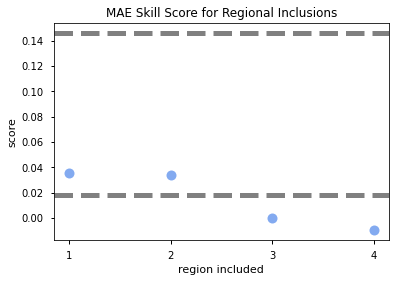

In [ ]:
linewidth = 5
markersize = 10
alpha = .8

plt.axhline(y_plot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.axhline(y_plot[-1], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.plot([1,2,3,4], y_plot[:-2], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

plt.ylabel('score')
plt.xlabel('region included')
plt.xticks([1,2,3,4])

plt.grid(False)

plt.title('MAE Skill Score for Regional Inclusions')
plt.show()
#plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
# plt.plot(masked_inclusion_weight_sum, y_plot, 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)
# plt.xlabel('sum of included weights')
# plt.ylabel('score')

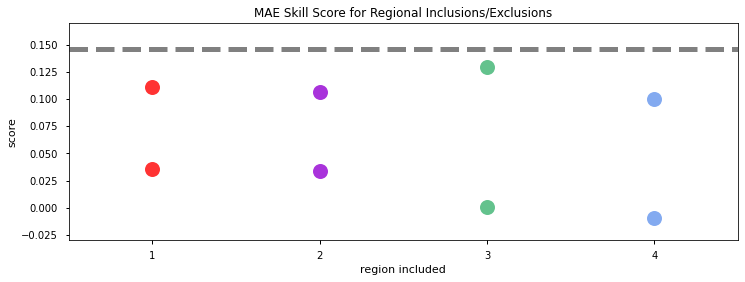

In [ ]:
linewidth = 5
markersize = 15
alpha = .8

colors = ['red', 'darkviolet', 'mediumseagreen', 'cornflowerblue']

plt.figure(figsize=(12, 4))
linevals = []
lineval = plt.axhline(prev_yplot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
linevals.append(lineval)
for i, c in zip(range(4), colors):
    lineval = plt.plot([i+1], prev_yplot[i], 'o', label='Excluded', color=c, markersize=markersize, alpha=alpha)
    linevals.append(lineval)
    lineval = plt.plot([i+1], y_plot[i], 'o', label='Included', color=c, markersize=markersize, alpha=alpha)
    linevals.append(lineval)

plt.ylabel('score')
plt.xlabel('region included')
plt.xticks([1,2,3,4])
plt.xlim(.5, 4.5)
plt.ylim(-.03, .17)

plt.grid(False)

plt.title('MAE Skill Score for Regional Inclusions/Exclusions')

fig_savename = 'exclusion_inclusion_scores'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Print out the values
for i in range(len(linevals)):
    try:
        print(linevals[i].get_ydata()[0])
    except:
        print(linevals[i][0].get_ydata()[0])

0.1461864055679174
0.11134040094528952
0.035879442562074204
0.10654914760043943
0.03405472064923698
0.12958484453188024
0.0003517878564266441
0.0999013573326396
-0.009758508367307295


# Figures 2 and 3: North Atlantic Decadal Predictions

In [ ]:
exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735



[[0.23540417]]


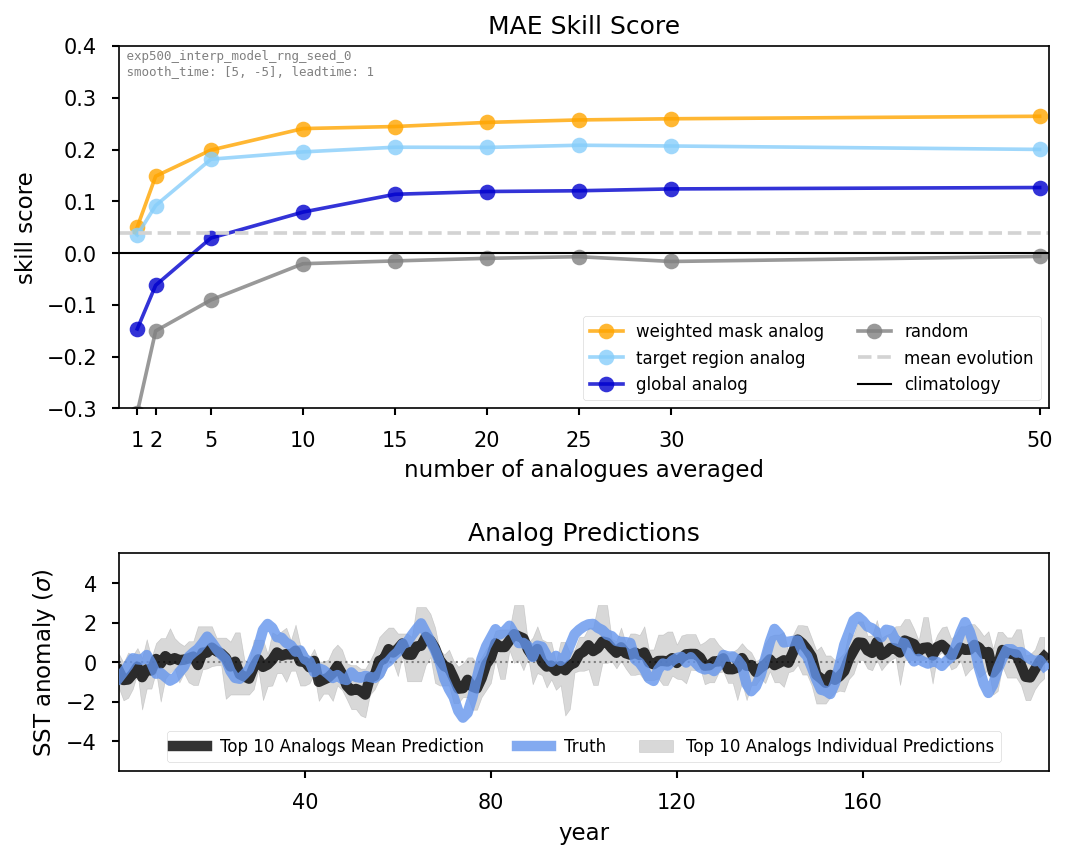

In [ ]:
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()

for line in [0, 3, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[1].set_label('weighted mask analog')
lines[2].set_label('target region analog')
lines[4].set_label('global analog')
lines[8].set_label('mean evolution')

# Change a color
#lines[2].set_color('deepskyblue')
#lines[3].set_color('mediumblue')
lines[8].set_color('lightgray')
lines[8].set_alpha(1)

# Change order
lines[0].set_zorder(0)

# Add climo
plt.axhline(0, color = 'black', linewidth = 1, label='climatology')

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

###
### PREDICTIONS PART
###

plt.subplot(2, 1, 2)

start_year = 150
num_years = 200
end_year = start_year + num_years
analog_vals = predictions[start_year:end_year,0] 
analog_mins = predictions[start_year:end_year,1]
analog_maxs = predictions[start_year:end_year,2]
truth_vals = soi_output[start_year:end_year]
#plt.figure(figsize=(8, 2.5))

linewidth = 5
alpha = .8

plt.axhline(0, zorder=0, color='gray', linestyle='dotted', alpha=1, linewidth=1)
plt.plot(analog_vals, label='Top 10 Analogs Mean Prediction', color='k', linewidth=linewidth, alpha=alpha, zorder=2)
plt.plot(truth_vals, label='Truth', color='cornflowerblue', linewidth=linewidth, alpha=alpha, zorder=3)
plt.fill_between(range(len(analog_mins)), analog_mins, analog_maxs, color='gray', alpha = .3, zorder=1,
                 label='Top 10 Analogs Individual Predictions')

plt.ylabel('SST anomaly ($\sigma$)')
plt.xlabel('year')
plt.xlim(0, num_years)
plt.xticks(np.arange(num_years//5,num_years,num_years//5))
plt.yticks([-4, -2, 0, 2, 4])

plt.ylim(-5.5, 5.5)
plt.grid(False)
plt.legend(fontsize=8, ncol=3, loc="lower center",)
plt.title('Analog Predictions')

fig_savename = 'Figure3'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
## Plot the Mask, plus the Mask times Input and Best Analog (Figure 2)
imp.reload(metrics)
imp.reload(plots)

# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output

best_analog_maps = np.zeros(soi_input.shape) * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    best_analog_maps  = model_diagnostics.run_complex_operations(metrics.get_best_analog,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)


In [ ]:
import matplotlib.ticker as mticker

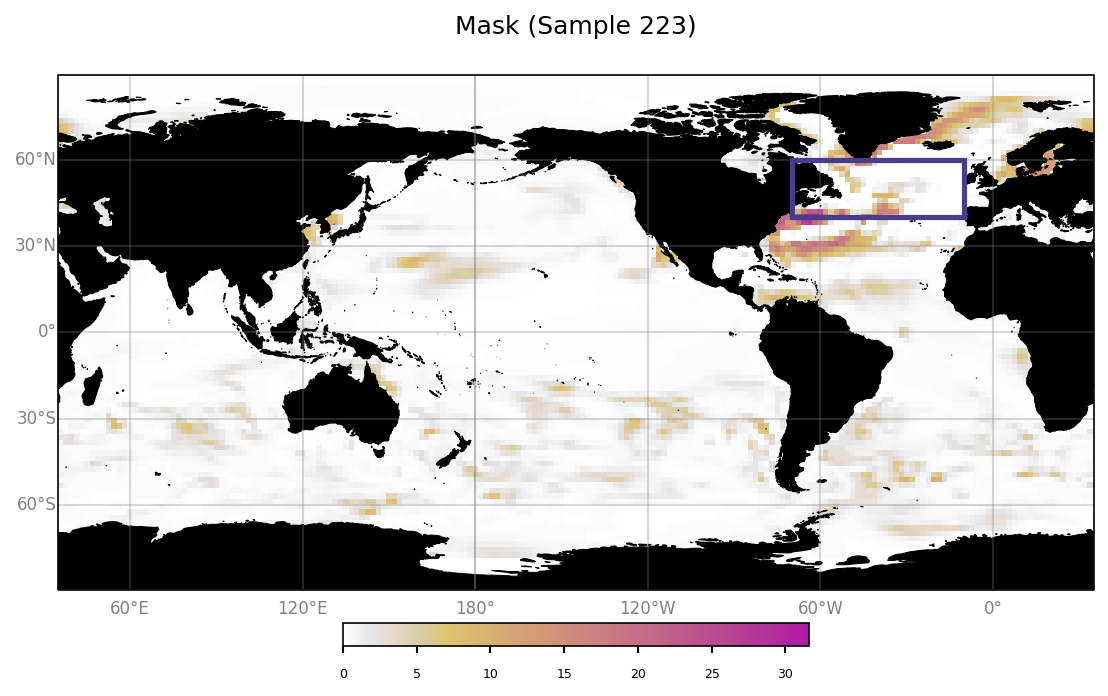

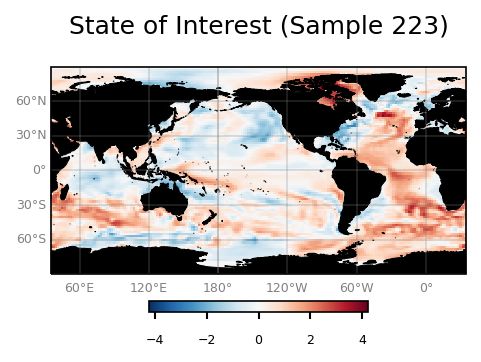

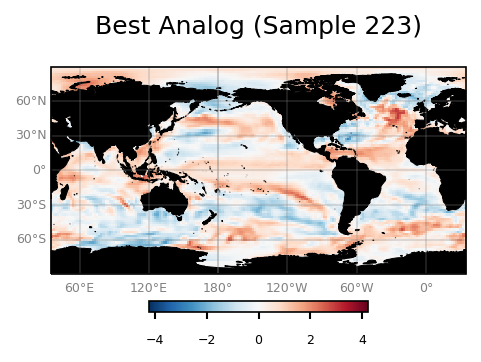

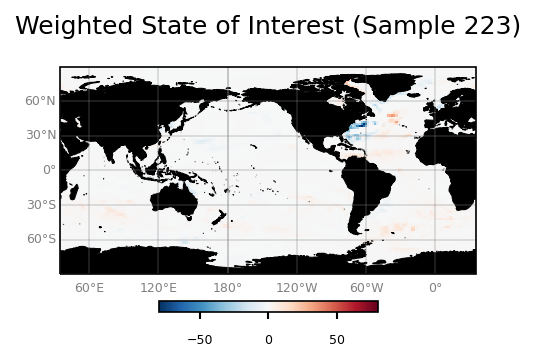

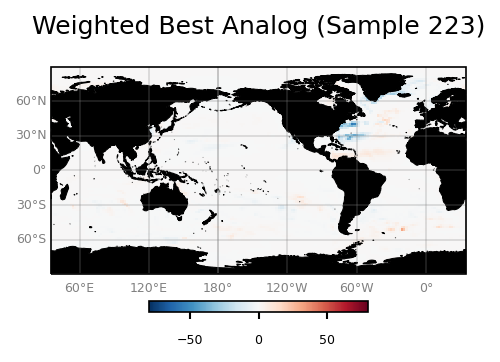

In [ ]:
sample_num = 223
analog_map = best_analog_maps[sample_num]
soi_map = soi_input[sample_num]
things_to_plot = np.array([mask, soi_map, analog_map, soi_map * mask, analog_map * mask])
titles = np.array(['Mask', 'State of Interest', 'Best Analog', 'Weighted State of Interest', 'Weighted Best Analog'])
plottypes = np.array(['mask', 'input', 'input', 'weighted', 'weighted'])
cmaps = [None, 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r']
climitss = []

for plottype in plottypes:
    items_to_climit = np.stack(things_to_plot[plottypes == plottype])
    if plottype == 'mask':
        climitss.append((0, items_to_climit.max()))

    else:
        climits_abs = np.abs(items_to_climit).max()
        climitss.append((-climits_abs, climits_abs))

for plotmap, title, climits, cmap, plottype in zip(things_to_plot, titles, climitss, cmaps, plottypes):

    fig_savename = 'map_of_' + title.strip() + '_sample=' + str(sample_num)
    num_maps = plotmap.shape[-1]
    ax = dict()

    if plottype == 'mask':
        linewidth = 1
        fig = plt.figure(figsize=(7.5 * num_maps, 5))
    else:
        linewidth = .75
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))

    # Plotting the region box specs
    edgecolor = 'darkslateblue'
    region_bool = False
    if plottype == 'mask':
        region_bool = True

    for imap in range(num_maps):
        cbarpad = .1
        if plottype == 'mask':
            cbarpad = .05
        ax, _ = plots.plot_interp_masks(fig, settings, plotmap[..., imap], lat=lat, lon=lon, cmap=cmap,
                                            central_longitude=215., climits = climits, title_text=title + ' (Sample ' + \
                                                str(sample_num) + ')',
                                            subplot=(1, num_maps, imap + 1), use_text=False, 
                                            region_bool=region_bool, edgecolor = edgecolor, cbarpad=cbarpad)

        gl = ax.gridlines(draw_labels=True, color='gray', linestyle='-', linewidth=linewidth, alpha=.3)
        gl.xlabel_style = {'size': 8*linewidth, 'color': 'gray'}
        gl.ylabel_style = {'size': 8*linewidth, 'color': 'gray'}
        gl.xpadding = 5 * linewidth
        gl.ypadding = 5 * linewidth   

        plt.draw()

        for l in gl.ylabel_artists:
            if l._x > -40:
                l.set(alpha=0)

        for l in gl.xlabel_artists:
            if l._y > 0:
                l.set(alpha=0)

    plt.tight_layout()
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

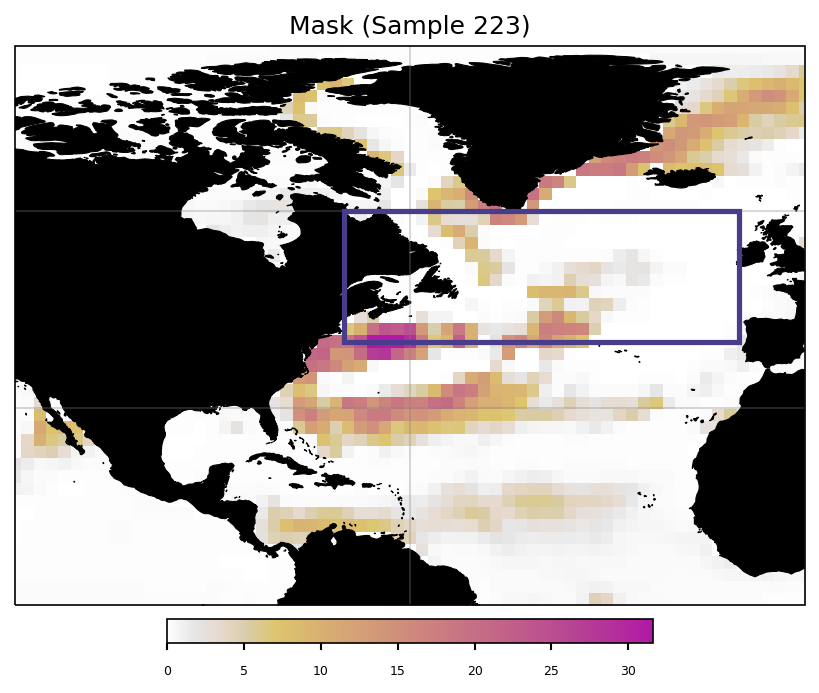

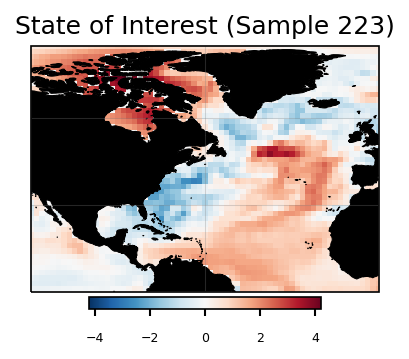

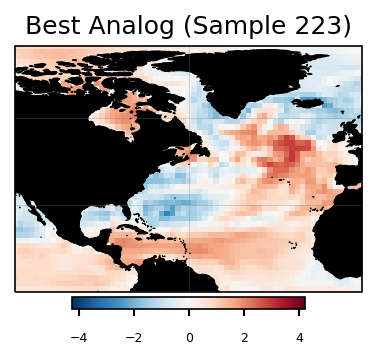

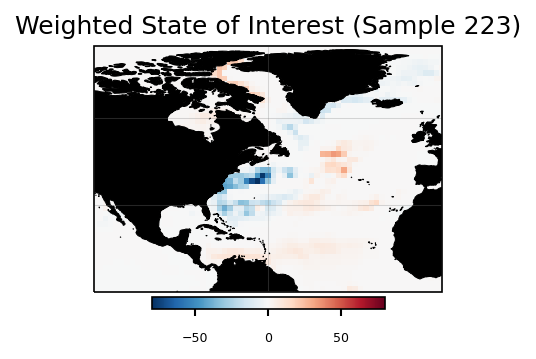

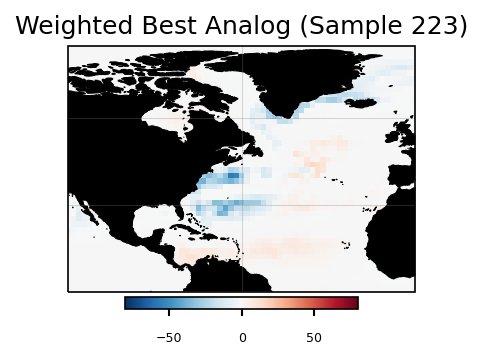

In [ ]:
### ZOOMED IN ON THE IMPORTANT REGIONS

for plotmap, title, climits, cmap, plottype in zip(things_to_plot, titles, climitss, cmaps, plottypes):

    fig_savename = 'zoomedmap_of_' + title.strip() + '_sample=' + str(sample_num)
    num_maps = plotmap.shape[-1]
    ax = dict()

    if plottype == 'mask':
        linewidth = 1
        fig = plt.figure(figsize=(7.5 * num_maps, 5))
    else:
        linewidth = .5
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))

    # Plotting the region box specs
    edgecolor = 'darkslateblue'
    region_bool = False
    if plottype == 'mask':
        region_bool = True

    for imap in range(num_maps):
        ax, _ = plots.plot_interp_masks(fig, settings, plotmap[..., imap], lat=lat, lon=lon, cmap=cmap,
                                            central_longitude=215., climits = climits, title_text=title + ' (Sample ' + \
                                                str(sample_num) + ')',
                                            subplot=(1, num_maps, imap + 1), use_text=False, 
                                            region_bool=region_bool, edgecolor = edgecolor)
        ax.set_extent([240, 360, 0, 80])

        gl = ax.gridlines(draw_labels=False, color='gray', linestyle='-', linewidth=linewidth, alpha=.3)        
        gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
        gl.xlocator = mticker.FixedLocator([-120, -60, 0])
    
    #plt.xlim(240, 360)
    #plt.ylim(0, 90)
    plt.tight_layout()
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

# Figure 4

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770

[[0.15828237]]


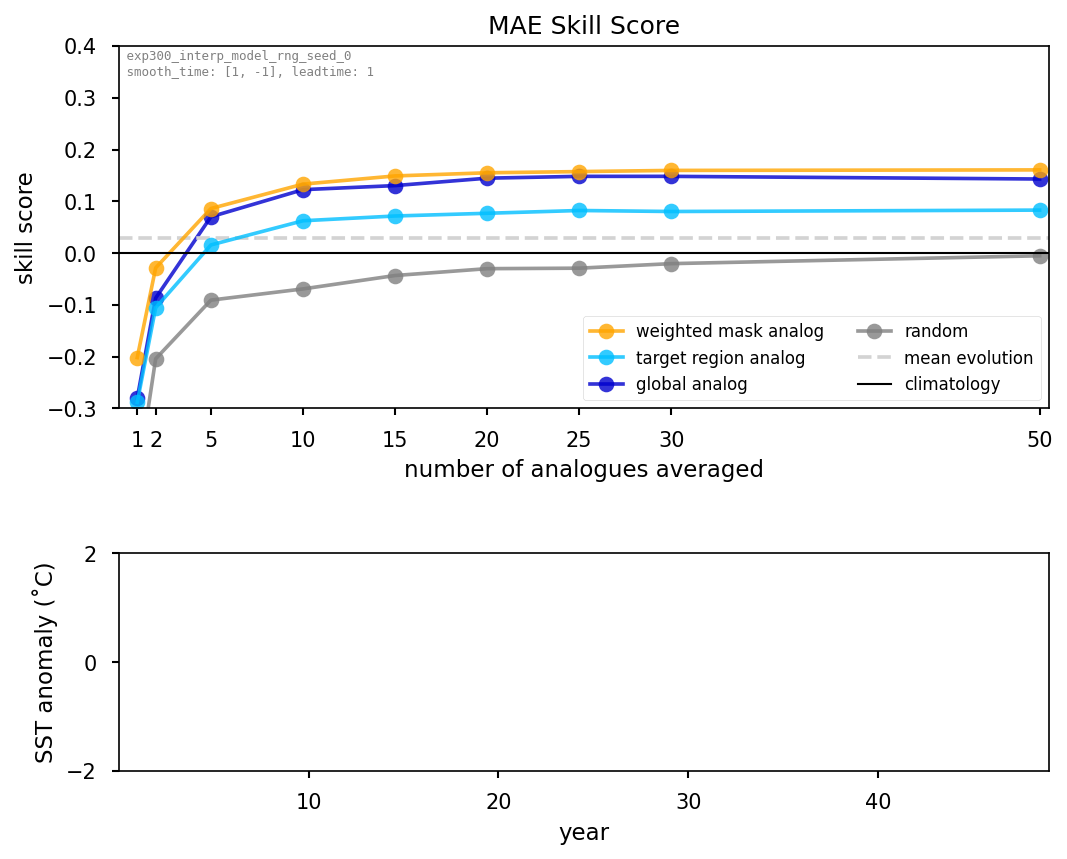

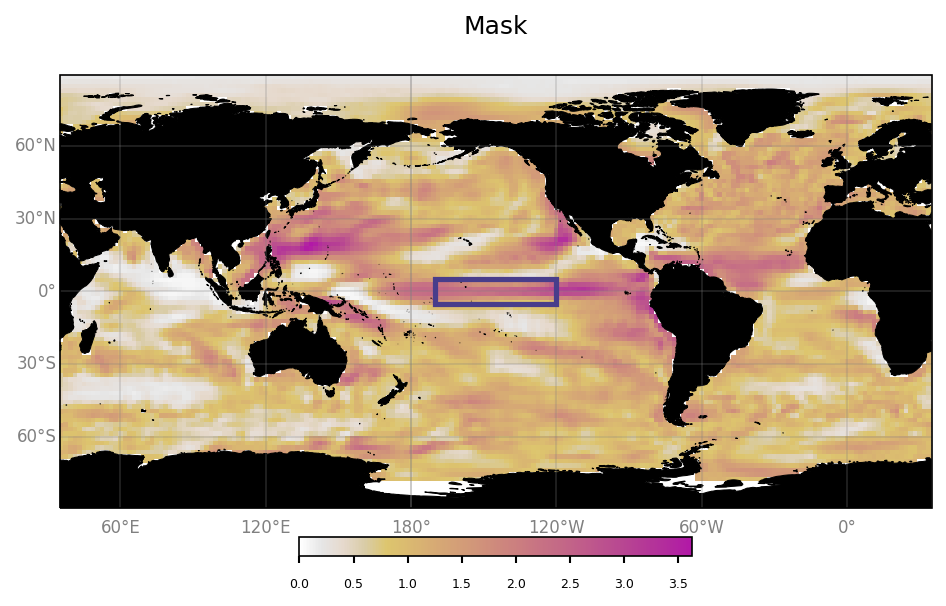

In [ ]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [0, 3, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[1].set_label('weighted mask analog')
lines[2].set_label('target region analog')
lines[4].set_label('global analog')
lines[8].set_label('mean evolution')

# Change a color
lines[2].set_color('deepskyblue')
lines[3].set_color('mediumblue')
lines[8].set_color('lightgray')
lines[8].set_alpha(1)

# Change order
lines[8].set_zorder(0)
lines[4].set_zorder(0)

# Add climo
plt.axhline(0, color = 'black', linewidth = 1, label='climatology')

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

# This stuff just keeps the second subplot the exact same as in Figure 3
plt.subplot(2, 1, 2)

plt.ylabel('SST anomaly (˚C)')
plt.xlabel('year')
plt.xlim(0, 49)
plt.xticks(np.arange(10,50,10))
plt.yticks([-2, 0, 2])

fig_savename = 'Figure4b'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
#^ Note, keeping two panels here so it has the same shape as the one in the first part of the paper.
ax = dict()

fig = plt.figure(figsize=(7.5 * 1, 5))

# Plotting the region box specs
edgecolor = 'darkslateblue'
region_bool = True
climits = [mask.min(), mask.max()]
ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 0], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text="Mask",
                                    subplot=(1, 1, 1), use_text=False, 
                                    region_bool=region_bool, edgecolor = edgecolor, cbarpad=.05)

gl = ax.gridlines(draw_labels=True, color='gray', linestyle='-', linewidth=linewidth, alpha=.3)
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}
gl.xpadding = 5
gl.ypadding = 5 

plt.draw()

for l in gl.ylabel_artists:
    if l._x > -40:
        l.set(alpha=0)

for l in gl.xlabel_artists:
    if l._y > 0:
        l.set(alpha=0)

fig_savename = 'Figure4a'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

# Figure S2 (exp500), S3 (exp300)

In [ ]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['model_type'] = model_type

# init things
mask_list = []
skill_list = []

for seed in range(10, 100, 10):
    settings['rng_seed'] = seed

    savename_prefix = (
            exp_name
            + "_" + settings["model_type"] + "_"
            + f"rng_seed_{settings['rng_seed']}"
    )
    settings["savename_prefix"] = savename_prefix

    model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                        [soi_train_input, analog_input])
    # Get the mask
    mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)

    rng_string = "rng_seed_" + str(settings["rng_seed"])

    # GET THE METRICS DATA
    with open(dir_settings["metrics_directory"] + settings[
        "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
        plot_metrics = pickle.load(f)
    with open(dir_settings["metrics_directory"] + settings[
        "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
        ann_analog_metrics = pickle.load(f)
    with open(dir_settings["metrics_directory"] + settings[
        "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
        ann_metrics = pickle.load(f)

    plot_metrics['error_ann_analog'] = ann_analog_metrics['error_network']
    plot_metrics['error_ann'] = ann_metrics['error_network']

    mask_list.append(mask)
    skill_list.append(plot_metrics)


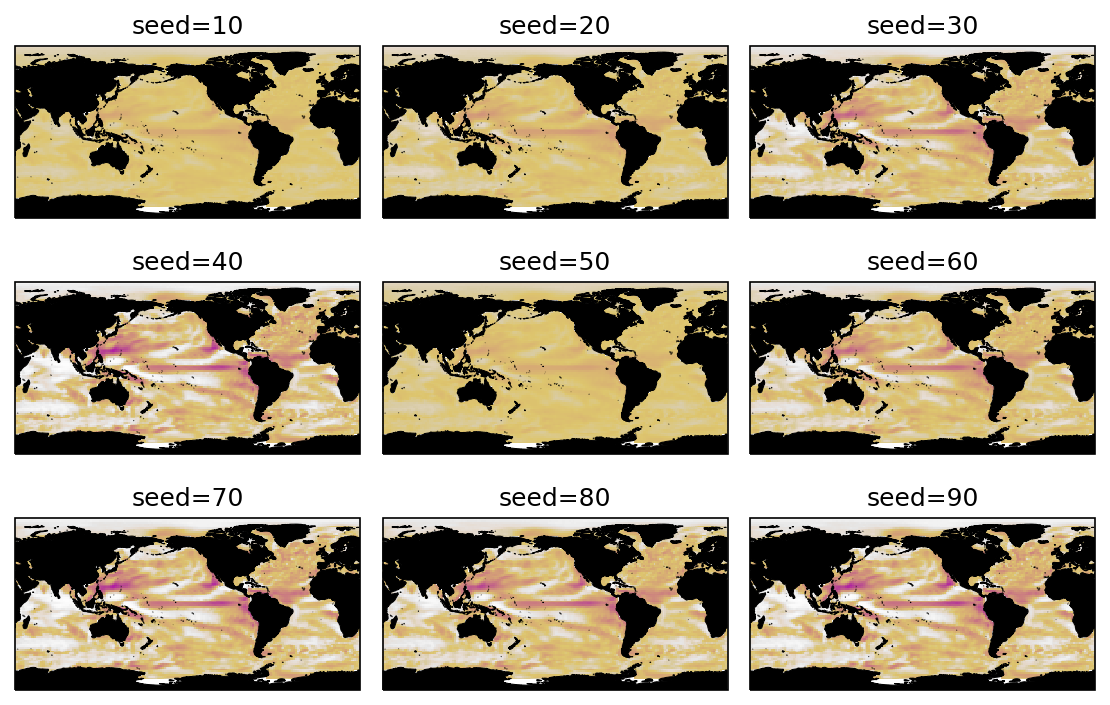

In [ ]:
fig = plt.figure(figsize=(7.5 * 1, 5))

climits = (0, np.max(mask_list))
for imask, mask in enumerate(mask_list):
    ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 0], lat=lat, lon=lon, cmap=None,
                                        central_longitude=215., climits = climits, title_text='seed=' + str((imask+1)*10),
                                        subplot=(3, 3, imask + 1), use_text=False, 
                                        region_bool=False, edgecolor = 'darkslateblue', cbarBool=False)
plt.tight_layout()

fig_savename = 'all_masks'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

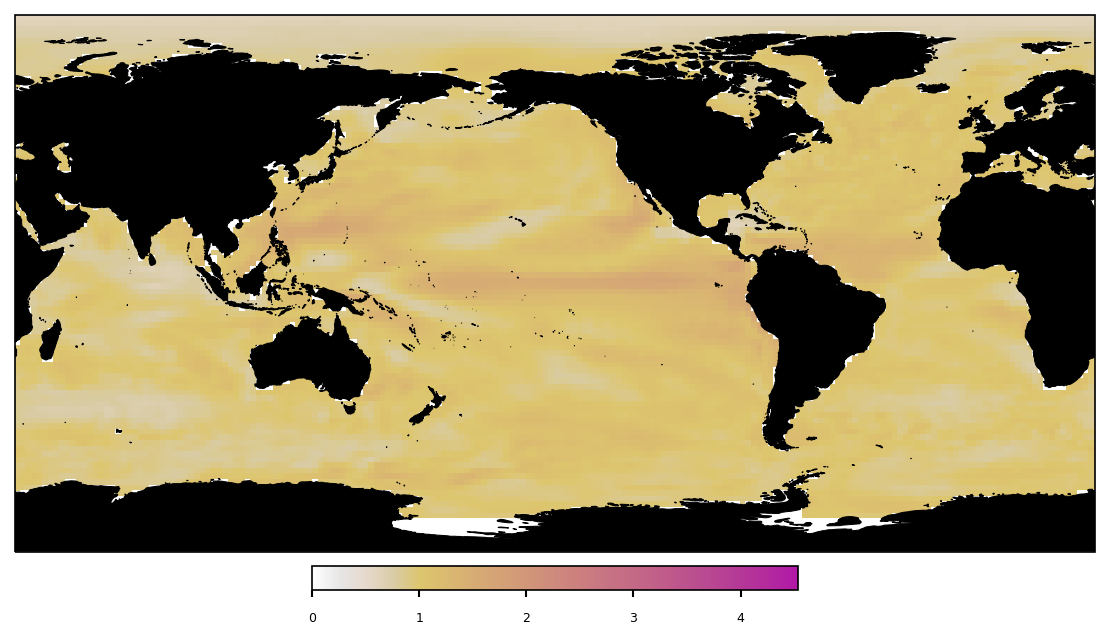

In [ ]:
fig = plt.figure(figsize=(7.5 * 1, 5))

climits = (0, np.max(mask_list))

ax, _ = plots.plot_interp_masks(fig, settings, mask_list[0][..., 0], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text='',
                                    subplot=(1, 1, 1), use_text=False, 
                                    region_bool=False, edgecolor = 'darkslateblue', cbarBool=True)
plt.tight_layout()

fig_savename = 'all_masks_colorbar'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

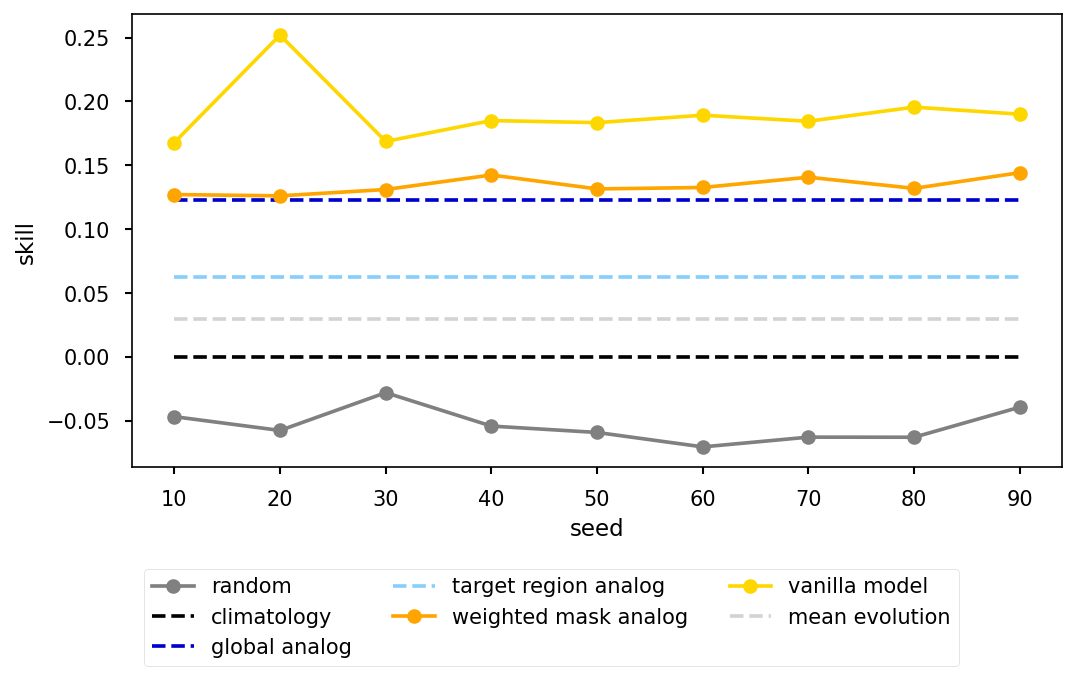

In [ ]:

# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

if exp_name == "exp500":
    targreg_name = 'N. Atl.'
elif exp_name == "exp300":
    targreg_name = 'niño3.4'

metrics_names = ["error_random", "error_climo", "error_globalcorr", "error_corr", "error_network", "error_ann", 
           "error_ann_analog", "error_custom"]
styles = ["-", '--', '--', '--', '-', '-', '-', '--']
colors = ["gray", "k", "mediumblue", "lightskyblue", "orange", "gold", "red", "lightgray"]
markers = ["o", "", "", "" , "o", "o", "o", ""]
labels = ["random", "climatology", "global analog", 'target region analog', 'weighted mask analog', 'vanilla model',
          "vanilla analog model", "mean evolution"]

xs = []
ys = []

for iskill in range(1,10):
    xs.append((iskill)*10)

for plot_metrics in skill_list:
    y = []
    for metric_name in metrics_names:
        all_skills = metrics.eval_function(plot_metrics[metric_name])
        if all_skills.size == 1:
            this_skill = all_skills
        else:
            this_skill = all_skills[np.array(plot_metrics["analogue_vector"]) == N_ANALOGS][0]
        this_skill = 1 - this_skill / metrics.eval_function(plot_metrics["error_climo"])
        y.append(this_skill)
    ys.append(y)

plt.plot(xs, ys)

lines = ax.get_lines()

for line in range(len(lines)):
    #lines[line].set_label('')
    lines[line].set_linestyle(styles[line])
    lines[line].set_color(colors[line])
    lines[line].set_marker(markers[line])
    lines[line].set_label(labels[line])

# Remove ann analog
lines[6].remove()

plt.legend(bbox_to_anchor=(.9, -.2), ncol = 3)
plt.ylabel('skill')
plt.xlabel('seed')

fig_savename = 'all_skill_scores'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

# Figure S5

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp501.pickle
   analog data
 # analog samples = 5075
   training data
 # soi samples = 2175
   validation data
   # soi samples = 725
   testing data
  # soi samples = 725

[[0.25588634]]


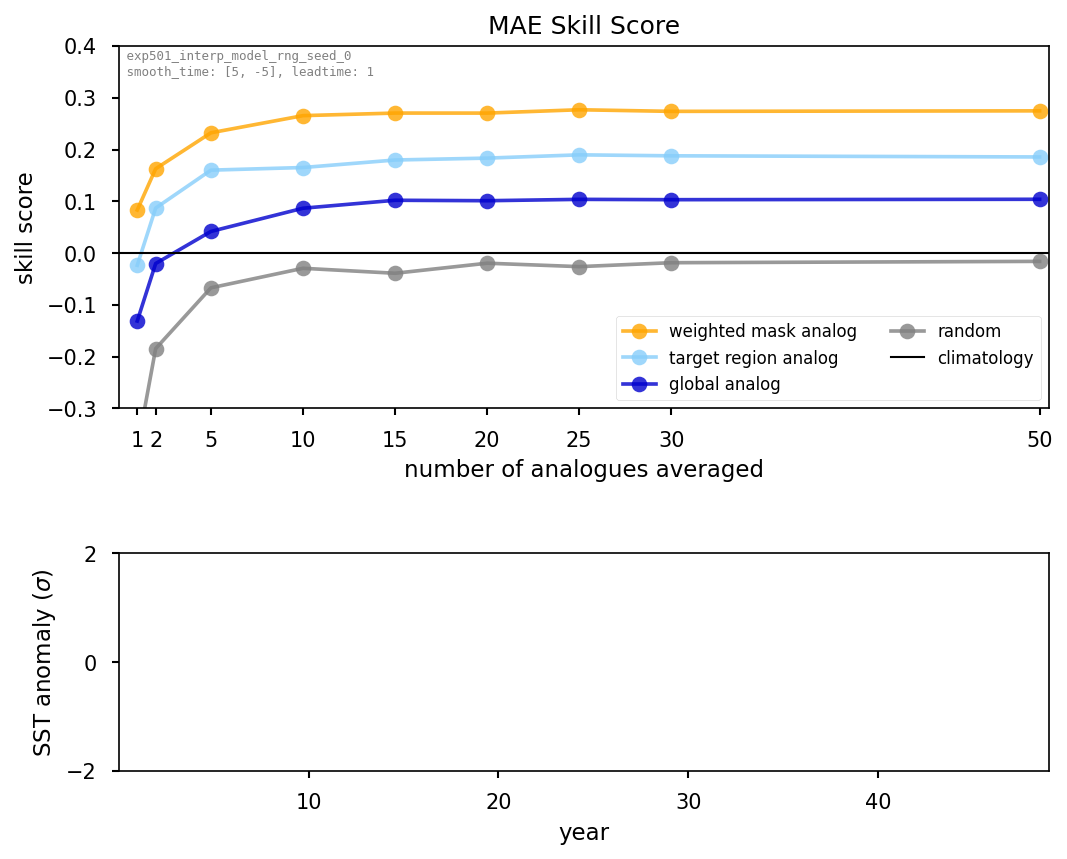

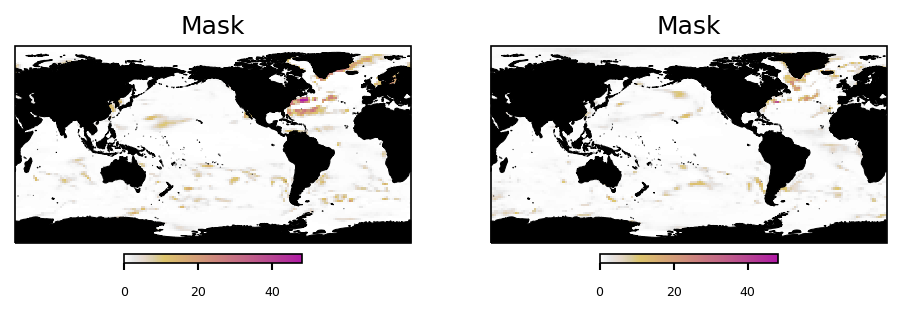

In [ ]:
exp_name = 'exp501'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [0, 3, 6, 7, 8]:
    lines[line].remove()

# # Update some line labels
lines[1].set_label('weighted mask analog')
lines[2].set_label('target region analog')
lines[4].set_label('global analog')

# # Change a color
# lines[2].set_color('deepskyblue')
# lines[3].set_color('mediumblue')
# lines[8].set_color('lightgray')

# Change order
lines[4].set_zorder(0)

# Add climo
plt.axhline(0, color = 'black', linewidth = 1, label='climatology')

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

# This stuff just keeps the second subplot the exact same as in Figure 3
plt.subplot(2, 1, 2)

plt.ylabel('SST anomaly ($\sigma$)')
plt.xlabel('year')
plt.xlim(0, 49)
plt.xticks(np.arange(10,50,10))
plt.yticks([-2, 0, 2])

fig_savename = 'FigureS5b'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
#^ Note, keeping two panels here so it has the same shape as the one in the first part of the paper.
ax = dict()

fig = plt.figure(figsize=(7.5 * 1, 5))

# Plotting the region box specs
edgecolor = 'darkslateblue'
region_bool = False
climits = [0, mask.max()]
ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 0], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text="Mask",
                                    subplot=(1, 2, 1), use_text=False, 
                                    region_bool=region_bool, edgecolor = edgecolor)
ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 1], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text="Mask",
                                    subplot=(1, 2, 2), use_text=False, 
                                    region_bool=region_bool, edgecolor = edgecolor)

fig_savename = 'FigureS5a'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
imp.reload(model_diagnostics)

<module 'model_diagnostics' from '/Users/Jamin/Library/CloudStorage/GoogleDrive-jaminrader.science@gmail.com/My Drive/2023/WeightedMaskAnalogForecasting/model_diagnostics.py'>

# Export final weighted masks

In [20]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])

# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)

# Save the mask
np.savez('final_weighted_masks/' + exp_name + '.npz', mask=mask, lat=lat, lon=lon)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



(192,)

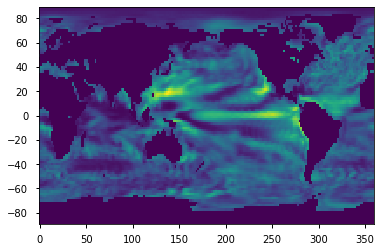

In [26]:
# Verify masks are right
exp_name = 'exp300'
mask_info = np.load('final_weighted_masks/' + exp_name + '.npz')
plt.pcolormesh(mask_info['lon'], mask_info['lat'], mask_info['mask'][..., 0])

mask_info['lon'].shape

# Sharpness Metric, Figure S1

In [ ]:
exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = [1,2,5,10,15,20,25,30,50,]
soi_input = soi_test_input
soi_output = soi_test_output

spreads500 = np.zeros((len(n_analogues), soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    spreads500[:,:]  = model_diagnostics.run_complex_operations(metrics.std_operation,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735



In [ ]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = [1,2,5,10,15,20,25,30,50,]
soi_input = soi_test_input
soi_output = soi_test_output

spreads300 = np.zeros((len(n_analogues), soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    spreads300[:,:]  = model_diagnostics.run_complex_operations(metrics.std_operation,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



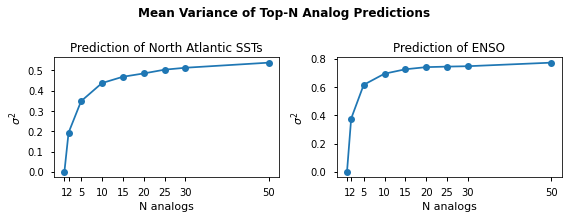

In [ ]:
plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(n_analogues, np.mean(spreads500**2, axis=0), 'o-')
plt.xticks(n_analogues)
plt.title('Prediction of North Atlantic SSTs')
plt.ylabel('$\sigma^2$')
plt.xlabel('N analogs')

plt.subplot(1,2,2)
plt.plot(n_analogues, np.mean(spreads300**2, axis=0), 'o-')
plt.xticks(n_analogues)
plt.title('Prediction of ENSO')
plt.ylabel('$\sigma^2$')
plt.xlabel('N analogs')

plt.suptitle('Mean Variance of Top-N Analog Predictions', y=1, fontweight='demi')

fig_savename = 'FigureS1'
plt.tight_layout()
plt.savefig(dir_settings["figure_custom_directory"] + fig_savename + '.png', dpi=300, bbox_inches='tight')


# Figure S6

In [ ]:
import regions


def rsq(y_pred, y_true):  
  ss_res = np.sum(np.square(y_true-y_pred))
  ss_tot = np.sum(np.square(y_true-np.mean(y_true)))
  return ( 1 - ss_res/(ss_tot + 10**-16) )

In [ ]:
exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output

# CALCULATE CORRELATION COEFFICIENT FOR THE WEIGHTED MASK (north atlantic)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
weighted_mask_corr_NA = np.corrcoef(predictions[:,0], soi_output)[0,1]
weighted_mask_rsq_NA = rsq(predictions[:,0], soi_output)

# CALCULATE CORRELATION COEFFICIENT FOR THE GLOBALLY UNIFORM MASK (north atlantic)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

mask = (mask *0 + 1) * np.cos(np.deg2rad(lat))[:, None, None]

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
global_mask_corr_NA = np.corrcoef(predictions[:,0], soi_output)[0,1]
global_mask_rsq_NA = rsq(predictions[:,0], soi_output)

# CALCULATE CORRELATION COEFFICIENT FOR THE REGIONALLY UNIFORM MASK (north atlantic)

soi_reg, lat_reg, lon_reg = build_data.extract_region(soi_input, regions.get_region_dict(
            settings["target_region_name"]), lat=lat, lon=lon)

lat_is_in_region = np.in1d(lat, lat_reg)
lon_is_in_region = np.in1d(lon, lon_reg)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

mask = (mask *0 + 1) * np.cos(np.deg2rad(lat))[:, None, None]
mask[~lat_is_in_region, ...] = 0
mask[:, ~lon_is_in_region, ...] = 0

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
region_mask_corr_NA = np.corrcoef(predictions[:,0], soi_output)[0,1]
region_mask_rsq_NA = rsq(predictions[:,0], soi_output)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735



In [ ]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model_diagnostics.retrieve_mask(model, settings, analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = N_ANALOGS
soi_input = soi_test_input
soi_output = soi_test_output

# CALCULATE CORRELATION COEFFICIENT FOR THE WEIGHTED MASK (enso)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
weighted_mask_corr_ENSO = np.corrcoef(predictions[:,0], soi_output)[0,1]
weighted_mask_rsq_ENSO = rsq(predictions[:,0], soi_output)

# CALCULATE CORRELATION COEFFICIENT FOR THE GLOBALLY UNIFORM MASK (enso)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

mask = (mask *0 + 1) * np.cos(np.deg2rad(lat))[:, None, None]

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
global_mask_corr_ENSO = np.corrcoef(predictions[:,0], soi_output)[0,1]
global_mask_rsq_ENSO = rsq(predictions[:,0], soi_output)

# CALCULATE CORRELATION COEFFICIENT FOR THE REGIONALLY UNIFORM MASK (enso)

soi_reg, lat_reg, lon_reg = build_data.extract_region(soi_input, regions.get_region_dict(
            settings["target_region_name"]), lat=lat, lon=lon)

lat_is_in_region = np.in1d(lat, lat_reg)
lon_is_in_region = np.in1d(lon, lon_reg)

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

mask = (mask *0 + 1) * np.cos(np.deg2rad(lat))[:, None, None]
mask[~lat_is_in_region, ...] = 0
mask[:, ~lon_is_in_region, ...] = 0

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
    
region_mask_corr_ENSO = np.corrcoef(predictions[:,0], soi_output)[0,1]
region_mask_rsq_ENSO = rsq(predictions[:,0], soi_output)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



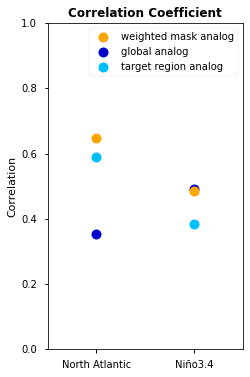

In [ ]:
c1 = 'orange'
c2 = 'mediumblue'
c3 = 'deepskyblue'

z1, z2, z3 = 1, 0, 0

plt.figure(figsize=(3.5,6))
for x, y, c, z in zip([0,0,0,1,1,1], 
                   [weighted_mask_corr_NA, global_mask_corr_NA, region_mask_corr_NA,
                         weighted_mask_corr_ENSO, global_mask_corr_ENSO, region_mask_corr_ENSO],
                    [c1, c2, c3, c1, c2, c3], [z1, z2, z3, z1, z2, z3]):
    plt.plot(x, y, 'o', color = c, markersize=10, zorder = z)
plt.xticks([0,1],['North Atlantic', 'Niño3.4'])
plt.xlim(-.5, 1.5)
plt.ylabel('Correlation')
plt.legend(['weighted mask analog', 'global analog', 'target region analog'])
plt.ylim(0, 1)
plt.title('Correlation Coefficient', fontweight='demi')

fig_savename = 'FigureS6'
plt.savefig(dir_settings["figure_custom_directory"] + fig_savename + '.png', dpi=300, bbox_inches='tight')

# Figure S7

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735

getting observations...
getting observations...
Analog Score:  0.3507616137820667
Uniform Analog Score:  0.14848626382331753
CFSSv2 Mean Score:  0.44946569204330444
CFSSv2 Ens 1 Score:  0.45458656549453735
CFSSv2 Ens 2 Score:  0.31016695499420166
CFSSv2 Ens 3 Score:  -0.12513399124145508
CFSSv2 Ens 4 Score:  0.13981276750564575
Analog Score:  0.7296514816309203
Uniform Analog Score:  0.5451480053649712
CFSSv2 Mean Score:  0.8559438195335969
CFSSv2 Ens 1 Score:  0.8320609531268637
CFSSv2 Ens 2 Score:  0.8608800266293073
CFSSv2 Ens 3 Score:  0.4410931551902123
CFSSv2 Ens 4 Score:  0.6872778229484939


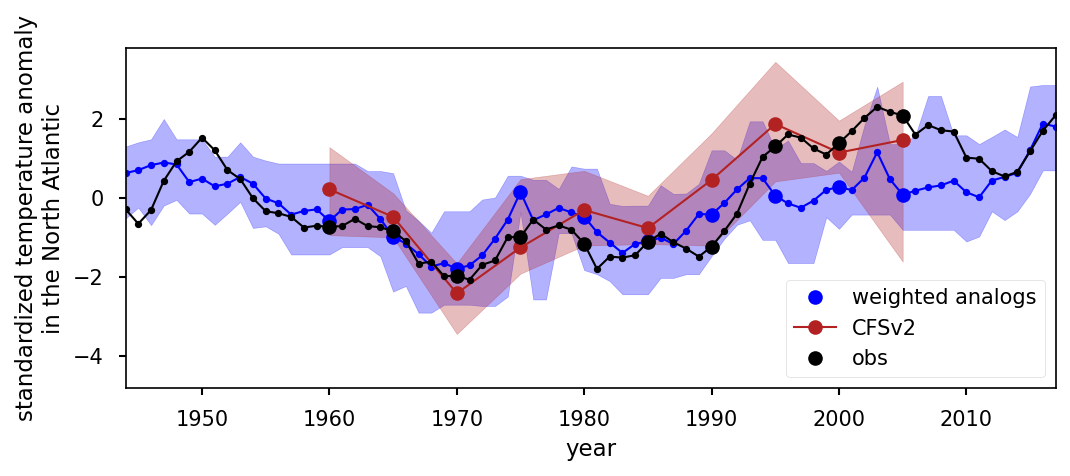

In [29]:
import pickle
import numpy as np
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import importlib as imp
import seaborn as sb
import cartopy.crs as ccrs

import experiments
import base_directories
import build_data
import save_load_model_run
import model_diagnostics
import metrics
import plots

import time
import numpy as np
import silence_tensorflow.auto
import tensorflow as tf
import build_data
import build_model
import metrics

import xarray as xr

import matplotlib as mpl

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
plt.style.use('seaborn-notebook')
dpiFig = 300

exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
output_standard_dict['ens_mean'].shape
# How much, at the end of the period, do we use for obs? Minus the years lost due to prediction leads
#part_obs_size = np.arange(1940, 2006, ).size - (np.arange(1850, 2006, ).size - input_standard_dict["ens_mean"].shape[0])
obs_year_end = 2022
num_correction_yrs = 20
actual_data_amount_diff = (np.arange(1850, 2006, ).size - input_standard_dict["ens_mean"].shape[0])
obs_size = np.arange(1940, obs_year_end + 1, ).size - actual_data_amount_diff
# Create observation standard dicts
none_input_standard_dict = dict()
none_output_standard_dict = dict()
none_input_standard_dict['ens_mean'] = np.zeros_like(input_standard_dict['ens_mean'][-(obs_size):].copy())
none_output_standard_dict['ens_mean'] = np.zeros_like(output_standard_dict['ens_mean'][-(obs_size):].copy())
none_input_standard_dict['data_mean'] = None
none_input_standard_dict['data_std'] = None
none_output_standard_dict['data_mean'] = None
none_output_standard_dict['data_std'] = None

# Pass obs_info
obs_info = {
    'target_filename' : 'skt_era5_1940-'+str(obs_year_end)+'_rMPI-GE.nc',
    'target_var' : "skt",
    'feature_filename' : 'skt_era5_1940-'+str(obs_year_end)+'_rMPI-GE.nc',
    'feature_var' : "skt",
    'input_standard_dict' : none_input_standard_dict,
    'output_standard_dict' : none_output_standard_dict,
}

# Get the observed data
settings['standardize_bool'] = False # don't standardize for now... need raw(ish) data
obs_input, obs_output, __, __, __, __ = \
    build_data.build_obs_data(settings, dir_settings["data_directory"], obs_info)
settings['standardize_bool'] = True 
# Make a standardization dictionary for the observations. 
# Create observation standard dicts
obs_input_standard_dict = input_standard_dict.copy()
obs_output_standard_dict = output_standard_dict.copy()
obs_input_standard_dict['ens_mean'] = np.full_like(input_standard_dict['ens_mean'][-(obs_size):].copy(), np.nan)
obs_output_standard_dict['ens_mean'] = np.full_like(output_standard_dict['ens_mean'][-(obs_size):].copy(), np.nan)
power = 0

nlats = obs_input.shape[1]
nlons = obs_input.shape[2]

# Landmask, so we don't compute bias correction for those locations
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
landmask = build_data.maskout_land_ocean(np.ones_like(mask).squeeze(), maskout="land").squeeze()[..., None]

x = np.arange(num_correction_yrs)

#obs_input_standard_dict['ens_mean'] = obs_input[:60].mean(axis=0)
#obs_output_standard_dict['ens_mean'] = obs_output[:60].mean(axis=0)

# Find the 'forced response' from the last num_correction_yrs of input data

# Linear regression for inputs
if power==1:
    ms = np.full(obs_input.shape[1:], np.nan)
    bs = np.full(obs_input.shape[1:], np.nan)
    for i in range(obs_input.shape[1]):
        for j in range(obs_input.shape[2]):
            m, b = np.polyfit(np.arange(obs_size), obs_input[:, i, j, 0], deg=power)
            ms[i,j,0] = m
            bs[i,j,0] = b

for iyr in range(obs_size):
    if power == 0:
        obs_input_standard_dict['ens_mean'][iyr] = obs_input.mean(axis=0)
    else:
        obs_input_standard_dict['ens_mean'][iyr] = ms*iyr+bs
    obs_output_standard_dict['ens_mean'][iyr] = obs_output.mean(axis=0)

# obs_input.shape
# plt.plot(obs_input_standard_dict['ens_mean'][:, 95, 20, 0], label='corrected ens mean', color = 'black')
# plt.plot(input_standard_dict['ens_mean'][:, 95, 20, 0], label='original ens mean', color = 'orange')
# plt.plot(obs_input[:, 95, 20, 0], label='observations', color = 'blue')
# plt.legend()
# plt.title('Feature Location: ilat=20,ilon=20')
# plt.show()

# plt.plot(obs_output_standard_dict['ens_mean'], label='corrected ens mean', color = 'black')
# plt.plot(output_standard_dict['ens_mean'], label='original ens mean', color = 'orange')
# plt.plot(obs_output, label='observations', color = 'blue')
# plt.legend()
# plt.title('Targets')
# plt.show()


obs_info['input_standard_dict'] = obs_input_standard_dict.copy()
obs_info['output_standard_dict'] = obs_output_standard_dict.copy()

final_obs_input, final_obs_output, __, __, __, __ = \
    build_data.build_obs_data(settings, dir_settings["data_directory"], obs_info)
uniform_mask = np.tile(np.cos(np.deg2rad(lat)), (1, mask.shape[1], 1)).T
imp.reload(metrics)

n_processes = 8
n_analogues = 10
soi_input = final_obs_input
soi_output = final_obs_output

obs_predictions_mask = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    obs_predictions_mask[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)



imp.reload(metrics)

n_processes = 8
n_analogues = 10
soi_input = final_obs_input
soi_output = final_obs_output



obs_predictions_uniformmask = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            uniform_mask)
    obs_predictions_uniformmask[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
yrs = np.arange(2023-obs_predictions_mask.shape[0]+settings['smooth_len_output'], 2023+settings['smooth_len_output'])
# plt.plot(yrs, obs_predictions_mask[:,0], '-b')
# plt.fill_between(yrs, obs_predictions_mask[:,1], obs_predictions_mask[:,2], color='blue', alpha = .2)
# plt.plot(yrs, final_obs_output, '-k')
# MAE = np.mean(np.abs(obs_predictions_mask[:,0] - final_obs_output))
# MAE_climo = np.mean(np.abs(np.mean(final_obs_output) - final_obs_output))
# print(1-MAE/MAE_climo)
# print(np.corrcoef(obs_predictions_mask[:,0], final_obs_output))
# plt.plot(obs_predictions_mask[:,0], final_obs_output, '.')
volcano_bool = False

DP_dir = '/Users/Jamin/LocalData/constraining_ensemble_projections/CFSv2_data/'
DP_years = range(1960, 2010, 5)
DP_mems = [1,2,3,4]

if volcano_bool:
    DP_mems=[1,2,3,]

if exp_name == 'exp500':
    latslice = slice(40, 60)
    lonslice = slice(360 - 70, 360 - 10)
elif exp_name == 'exp300':
    latslice = slice(-5, 5)
    lonslice = slice(360-170, 360-120)

firstds = True
for year in DP_years:
    firstda = True
    for imem in DP_mems:
    
        if volcano_bool and year <= 1990:
            volc_str = "decadal"
        else:
            volc_str = "noVolc"

        fn = "ts_Amon_CFSv2-2011_" + volc_str +  str(year) + "_r" + str(imem) + "i2p1_" + str(year) + "11-" + str(year+10) + "10.nc"
        ds = xr.open_dataset(DP_dir + fn)
        da = ds.ts
        da = da.expand_dims(dim='member', axis=0)
        da = da.isel(time=slice(2,abs(settings['smooth_len_output'])*12+2)).sel(lat=latslice).sel(lon=lonslice).mean()
        if firstda:
            DP_ds = da
            firstda = False
        else:
            DP_ds = xr.concat([DP_ds, da], dim='member')
    DP_ds['init_time'] = year
    if firstds:
        DP_ds_all = DP_ds
        firstds = False
    else:
        DP_ds_all = xr.concat([DP_ds_all, DP_ds], dim='init_time')

CFS_ts = DP_ds_all.values
CFS_time = DP_ds_all.init_time
CFS_ts_adj = ((CFS_ts - CFS_ts.mean()) - output_standard_dict['data_mean']) / output_standard_dict['data_std']
plt.figure(figsize=(8, 3))
yrs = np.arange(2023-obs_predictions_mask.shape[0]+settings['smooth_len_output'], 2023+settings['smooth_len_output'])
plt.plot(yrs, obs_predictions_mask[:,0], '-', marker='.', color='blue', linewidth = 1)
plt.plot(yrs[[y in CFS_time for y in yrs]], obs_predictions_mask[:,0][[y in CFS_time for y in yrs]], 'o', color='blue', label='weighted analogs')
plt.fill_between(yrs, obs_predictions_mask[:,1], obs_predictions_mask[:,2], color='blue', alpha = .3, zorder=0)

# plt.plot(yrs, obs_predictions_uniformmask[:,0], '-', marker='.', color='darkorange', linewidth = 1)
# plt.plot(yrs[[y in CFS_time for y in yrs]], obs_predictions_uniformmask[:,0][[y in CFS_time for y in yrs]], 'o', color='darkorange', label='weighted analogs')
# plt.fill_between(yrs, obs_predictions_uniformmask[:,1], obs_predictions_uniformmask[:,2], color='darkorange', alpha = .3, zorder=0)

plt.plot(CFS_time, CFS_ts_adj.mean(axis=1), color='firebrick', marker='o', linewidth=1, label='CFSv2')
plt.fill_between(CFS_time, CFS_ts_adj.min(axis=1), CFS_ts_adj.max(axis=1), color='firebrick', alpha=.3, zorder=0)

plt.plot(yrs, final_obs_output, '-k', marker='.', linewidth=1,)
plt.plot(yrs[[y in CFS_time for y in yrs]], final_obs_output[[y in CFS_time for y in yrs]], 'k', linestyle='', marker='o', linewidth=1, label='obs')

plt.legend(loc=4)
plt.xlim(yrs.min(), yrs.max())
plt.ylim(-4.8, 3.8)

plt.ylabel('standardized temperature anomaly\nin the North Atlantic')
plt.xlabel('year')

plt.savefig(dir_settings["figure_custom_directory"] + 'FigureS7.png', dpi=300, bbox_inches='tight')
cfs_obs = final_obs_output[[y in CFS_time for y in yrs]]
cfs_analogs = obs_predictions_mask[:,0][[y in CFS_time for y in yrs]]
cfs_uniform_analogs = obs_predictions_uniformmask[:,0][[y in CFS_time for y in yrs]]

def calc_mae_skill(obs, pred):
    MAE = np.mean(np.abs(obs - pred))
    MAE_climo = np.mean(np.abs(np.mean(obs) - obs))
    return 1-MAE/MAE_climo
print('Analog Score: ', calc_mae_skill(cfs_obs, cfs_analogs))
print('Uniform Analog Score: ', calc_mae_skill(cfs_obs, cfs_uniform_analogs))
print('CFSSv2 Mean Score: ', calc_mae_skill(cfs_obs, CFS_ts_adj.mean(axis=1)))
print('CFSSv2 Ens 1 Score: ', calc_mae_skill(cfs_obs, CFS_ts_adj[:, 0]))
print('CFSSv2 Ens 2 Score: ', calc_mae_skill(cfs_obs, CFS_ts_adj[:, 1]))
print('CFSSv2 Ens 3 Score: ', calc_mae_skill(cfs_obs, CFS_ts_adj[:, 2]))
if not volcano_bool:
    print('CFSSv2 Ens 4 Score: ', calc_mae_skill(cfs_obs, CFS_ts_adj[:, 3]))
print('Analog Score: ', np.corrcoef(cfs_obs, cfs_analogs)[0,1])
print('Uniform Analog Score: ', np.corrcoef(cfs_obs, cfs_uniform_analogs)[0,1])
print('CFSSv2 Mean Score: ', np.corrcoef(cfs_obs, CFS_ts_adj.mean(axis=1))[0,1])
print('CFSSv2 Ens 1 Score: ', np.corrcoef(cfs_obs, CFS_ts_adj[:, 0])[0,1])
print('CFSSv2 Ens 2 Score: ', np.corrcoef(cfs_obs, CFS_ts_adj[:, 1])[0,1])
print('CFSSv2 Ens 3 Score: ', np.corrcoef(cfs_obs, CFS_ts_adj[:, 2])[0,1])
if not volcano_bool:
    print('CFSSv2 Ens 4 Score: ', np.corrcoef(cfs_obs, CFS_ts_adj[:, 3])[0,1])
